In [41]:
# import utility modules
import pandas as pd
import numpy as np
import configparser
import os

import numpy as np
import pandas as pd
import latex

from scipy.optimize import minimize
from helpers.helper_classes import AddFeatureNames, Gene_SPCA, LoadingsSPCA
from helpers.helper_functions import get_data_pev
from joblib import dump, load

import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'ieee'])

In [48]:
# Read config.ini file
config = configparser.ConfigParser()
config.read('config.ini')

os.chdir(config['PATH']['ROOT_DIR'])

# Read data
data = load(config['PATH']['DATA_DIR'] + '/microarray-data-dict.lib')
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

# Read parameters
SEED = config.getint('PARAMS', 'SEED')
N_COMPONENTS = config.getint('PARAMS', 'N_COMPONENTS')

In [56]:
def get_spca(alpha, n_components = 20):
    spca_obj = LoadingsSPCA(alpha = alpha, max_iter = 10000, tol = 0.0001, n_components = n_components, n_jobs = -1, random_state=SEED)
    return spca_obj

def get_gene_spca(l1, n_components = 20):
    spca_obj = Gene_SPCA(max_iter = 10000, tol = 0.0000001, n_comps = n_components, l1 = l1)
    return spca_obj

def get_data_pev(X, n_components = 20, verbose = 0, step_size = 0.5, get_transform = get_spca):
    """ 
    Function that returns the explained variance of the first principal component for a single dataset versus 
    the number of non-zero loadings / genes

    Returns:
    - nonzero_columns_arr: array with number of columns with a non-zero influence on the first principal component
    - nonzero_loadings_arr: array with number of non-zero loadings of 'B' matrix
    - PEV_var_arr: array with explained variance of first principal component
    """

    # First obtain total variance
    pca = get_transform(0, n_components = n_components)
    _, R = np.linalg.qr(pca.fit_transform(X))
    total_var = sum(R[i][i]**2 for i in range(R.shape[0]))

    # Initialize values for loop
    nonzero_cnt = 999999999
    alpha_cur = 0

    # arrays
    nz_loadings = []
    nz_cols = []
    PEV_arr = []

    while nonzero_cnt > 200:

        # Obtain and fit spca object
        spca_cur = get_transform(alpha_cur, n_components = n_components)
        X_spca_cur = spca_cur.fit_transform(X)

        # Obtain PEV of first principal component
        _, R_cur = np.linalg.qr(X_spca_cur)
        explained_var_leading = R_cur[0][0]**2
        PEV = explained_var_leading / total_var

        # Count number of nonzero loadings and columns
        zero_rows = sum(np.count_nonzero(spca_cur.loadings[i,:]) == 0 for i in range(spca_cur.loadings.shape[0]))
        nonzero_cnt = X.shape[1] - zero_rows
        
        # Append values to arrays
        nz_cols.append(nonzero_cnt)
        nz_loadings.append(spca_cur.nonzero)
        PEV_arr.append(PEV)

        # Print values when verbose
        if verbose == 1:
            print("regularization = ", alpha_cur)
            print("nonzero columns = ", nonzero_cnt)
            print("nonzero loadings = ", spca_cur.nonzero)
            print("PEV = ", PEV)
            print("")

        # Update l1_cur
        alpha_cur += step_size
    
    return nz_cols, nz_loadings, PEV_arr

In [50]:
X = data['gravier']['none']['X_train']

In [51]:
# Golub because original, Christensen because of small dataset, Chin because of large dataset, Nakayama because of large number of classes

regularization =  0
nonzero columns =  1413
nonzero loadings =  28260
PEV =  0.33616530244513165

regularization =  0.8
nonzero columns =  1413
nonzero loadings =  12036
PEV =  0.09844002233502404

regularization =  1.6
nonzero columns =  1413
nonzero loadings =  6623
PEV =  0.07082641413993375

regularization =  2.4000000000000004
nonzero columns =  1411
nonzero loadings =  4620
PEV =  0.08022073420575652

regularization =  3.2
nonzero columns =  1401
nonzero loadings =  3502
PEV =  0.05849011944609173

regularization =  4.0
nonzero columns =  1385
nonzero loadings =  2816
PEV =  0.050596224983183606

regularization =  4.8
nonzero columns =  1346
nonzero loadings =  2273
PEV =  0.053694189041023174

regularization =  5.6
nonzero columns =  1267
nonzero loadings =  1835
PEV =  0.05517359913845032

regularization =  6.3999999999999995
nonzero columns =  1139
nonzero loadings =  1472
PEV =  0.049916544979678054

regularization =  7.199999999999999
nonzero columns =  956
nonzero loadings 

FileNotFoundError: [Errno 2] No such file or directory: './logs/pev_plots/plot_data.lib'

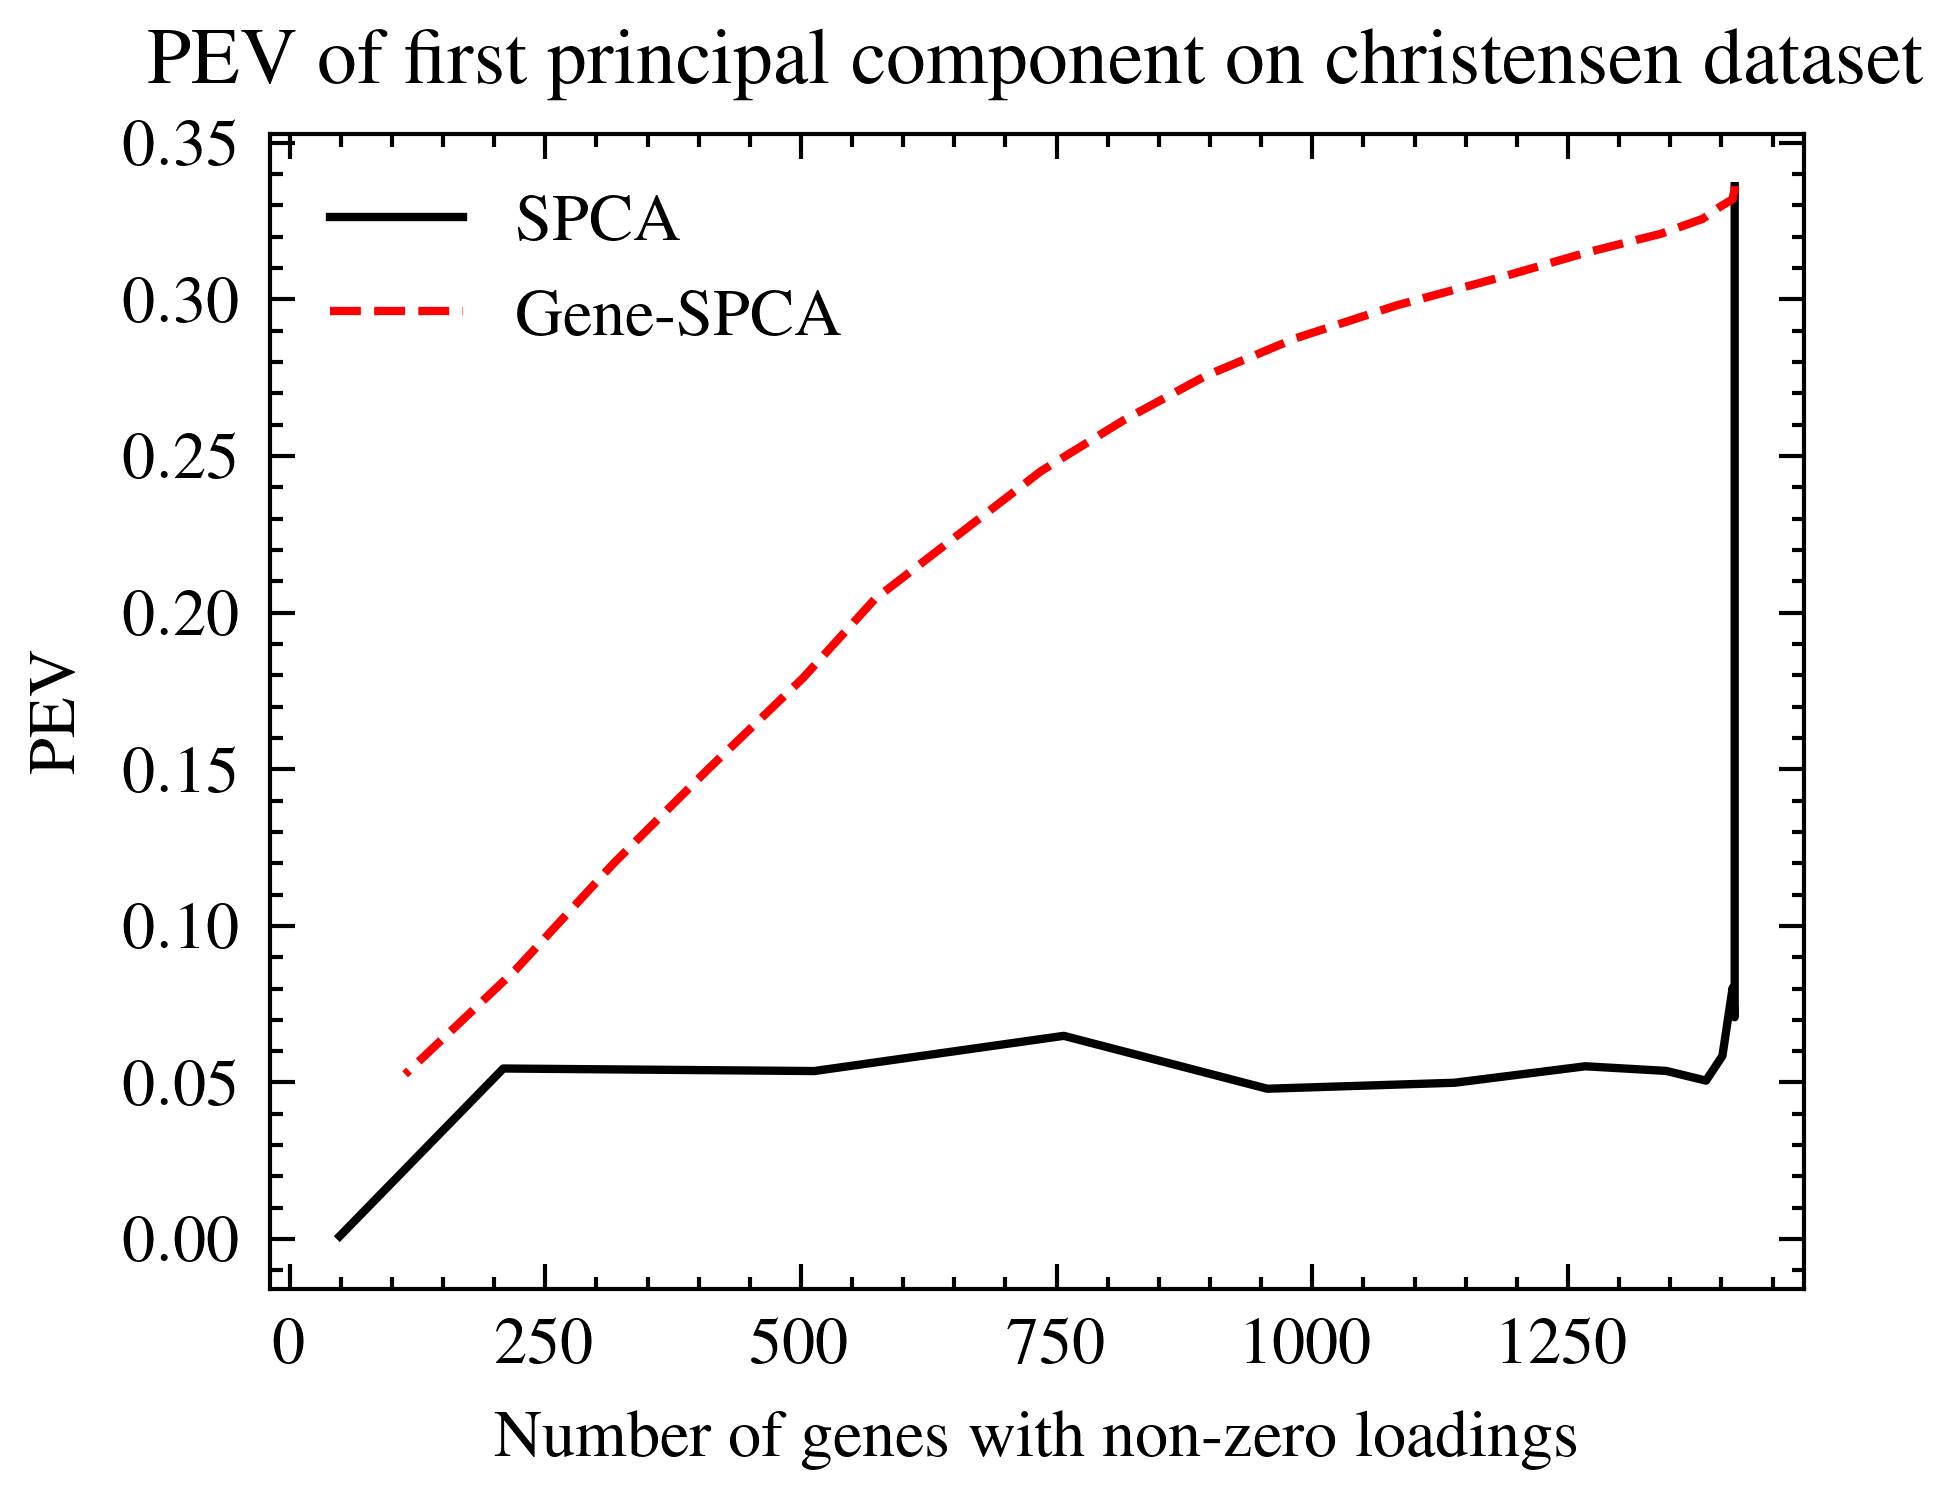

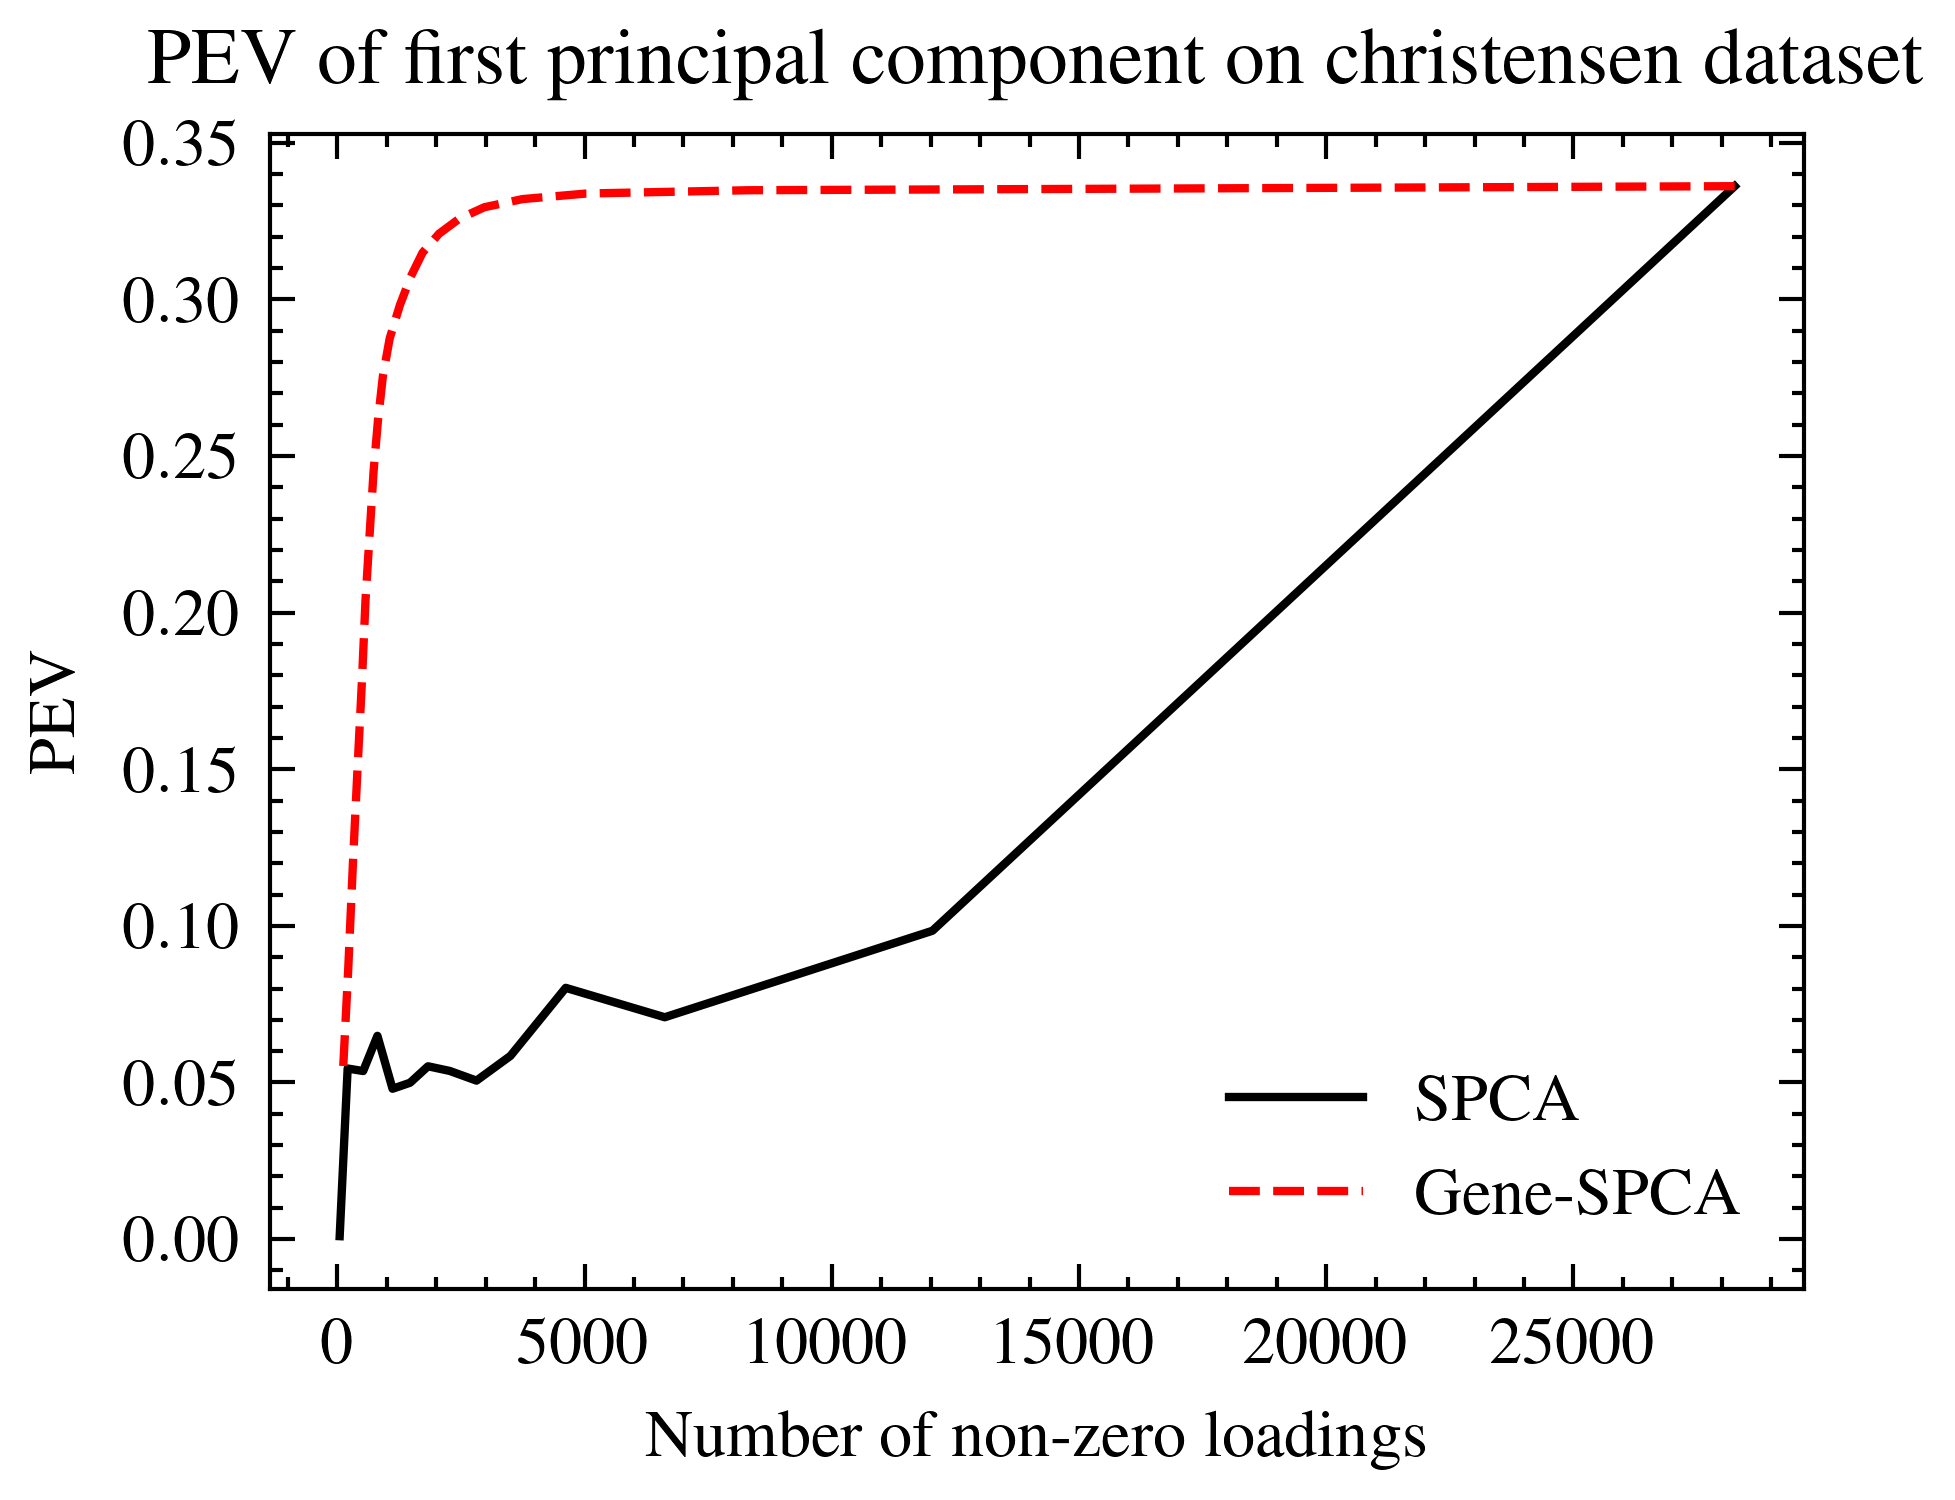

In [54]:
plot_dir = config['LOGGING']['FIG_DIR'] + '/pev_plots'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# pev_dataset_list = ['golub', 'christensen', 'chin', 'nakayama']
pev_dataset_list = ['christensen']
logging_dict = {}
for dname in pev_dataset_list:
    X = data[dname]['none']['X_train']
    
    nz_cols_spca, nz_loadings_spca, PEV_arr_spca = get_data_pev(X, n_components = 20, verbose = 1, step_size = 0.8, get_transform = get_spca)
    nz_cols_gspca, nz_loadings_gspca, PEV_arr_gspca = get_data_pev(X, n_components = 20, verbose = 1, step_size = 200, get_transform = get_gene_spca)
    
    # Plot PEV versus number of non-zero columns
    plt.plot(nz_cols_spca, PEV_arr_spca, label = 'SPCA')
    plt.plot(nz_cols_gspca, PEV_arr_gspca, label = 'Gene-SPCA')
    plt.legend()
    plt.title('PEV of first principal component on ' + dname + ' dataset')
    plt.xlabel('Number of genes with non-zero loadings')
    plt.ylabel('PEV')
    plt.savefig(plot_dir + '/' + dname + '_nzcols_pev.pdf')

    # Plot PEV versus number of non-zero loadings
    # create new plot
    plt.figure()
    plt.plot(nz_loadings_spca, PEV_arr_spca, label = 'SPCA')
    plt.plot(nz_loadings_gspca, PEV_arr_gspca, label = 'Gene-SPCA')
    plt.legend()
    plt.title('PEV of first principal component on ' + dname + ' dataset')
    plt.xlabel('Number of non-zero loadings')
    plt.ylabel('PEV')
    plt.savefig(plot_dir + '/' + dname + '_nzloadings_pev.pdf')
    
    
    logging_dict[dname] = {'spca': {'nz_cols': nz_cols_spca, 'nz_loadings': nz_loadings_spca, 'PEV_arr': PEV_arr_spca}, 'gspca': {'nz_cols': nz_cols_gspca, 'nz_loadings': nz_loadings_gspca, 'PEV_arr': PEV_arr_gspca}}
dump(logging_dict, config['LOGGING']['LOG_DIR'] + '/pev_plots/plot_data.lib')

In [55]:
dump(logging_dict, config['LOGGING']['LOG_DIR'] + '/pev_plots/plot_data.lib')


['./logs/pev_plots/plot_data.lib']

In [64]:
data

dname_list = []
for dname, _ in data.items():
    dname_list.append(dname)
dname_list

['yeoh',
 'nakayama',
 'golub',
 'khan',
 'west',
 'alon',
 'subramanian',
 'burczynski',
 'chin',
 'borovecki',
 'shipp',
 'tian',
 'gordon',
 'chiaretti',
 'sorlie',
 'chowdary',
 'sun',
 'pomeroy',
 'gravier',
 'su',
 'christensen',
 'singh']

In [63]:
dnames = os.listdir(config['PATH']['MICR_CSV'])
dnames

['subramanian_outputs.csv',
 'chowdary_outputs.csv',
 'golub_outputs.csv',
 'yeoh_outputs.csv',
 'nakayama_inputs.csv',
 'tian_outputs.csv',
 'chowdary_inputs.csv',
 'christensen_outputs.csv',
 'gravier_outputs.csv',
 'chiaretti_inputs.csv',
 'sun_outputs.csv',
 'nakayama_outputs.csv',
 'subramanian_inputs.csv',
 'su_inputs.csv',
 'golub_inputs.csv',
 'singh_inputs.csv',
 'borovecki_inputs.csv',
 'chiaretti_outputs.csv',
 'khan_outputs.csv',
 'gordon_outputs.csv',
 'singh_outputs.csv',
 'burczynski_inputs.csv',
 'west_outputs.csv',
 'west_inputs.csv',
 'su_outputs.csv',
 'gordon_inputs.csv',
 'sun_inputs.csv',
 'khan_inputs.csv',
 'chin_inputs.csv',
 'alon_outputs.csv',
 'pomeroy_inputs.csv',
 'yeoh_inputs.csv',
 'burczynski_outputs.csv',
 'pomeroy_outputs.csv',
 'sorlie_outputs.csv',
 'gravier_inputs.csv',
 'sorlie_inputs.csv',
 'borovecki_outputs.csv',
 'alon_inputs.csv',
 'chin_outputs.csv',
 'shipp_inputs.csv',
 'christensen_inputs.csv',
 'shipp_outputs.csv',
 'tian_inputs.csv']

Text(0, 0.5, 'PEV')

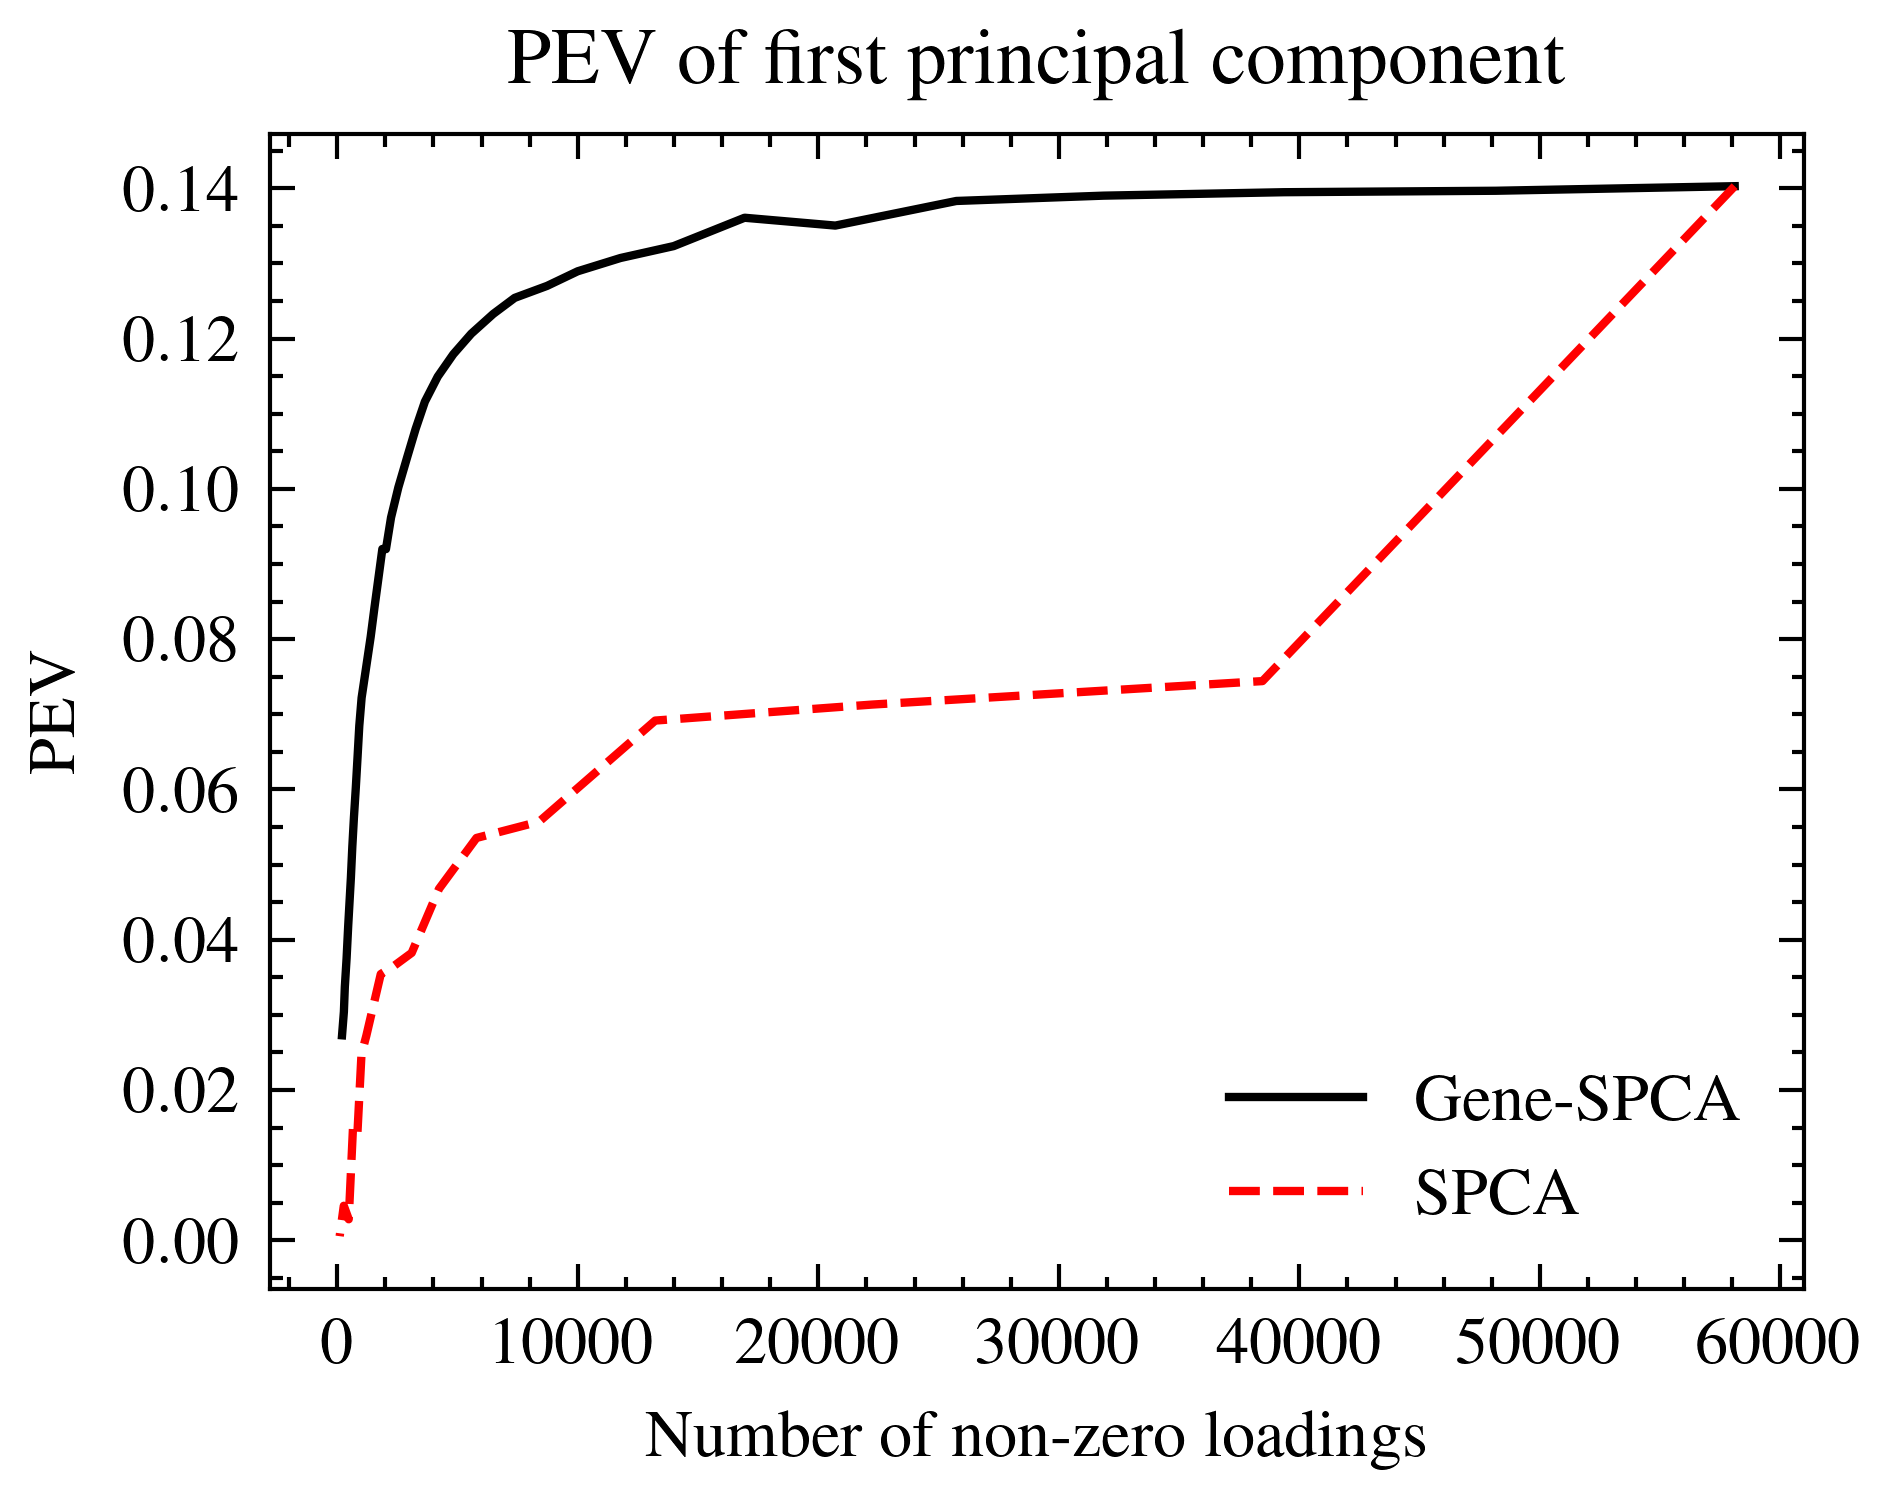

In [39]:
plt.plot(nz_loads, pev_gravier, label = 'Gene-SPCA')
plt.plot(nz_loadss, pev_gravierss, label = 'SPCA')
plt.legend()
plt.title('PEV of first principal component')
plt.xlabel('Number of non-zero loadings')
plt.ylabel('PEV')